In [20]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
import os
import shap
import json

# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now you can import from config
from config import config
from workflows import generate_data as gd
import prompts.prompt_generator as pg
from evaluation import judge

from clients.azure_openai_client import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
config.AZURE_OPENAI

{'endpoint': 'https://your-endpoint.openai.azure.com/',
 'api_key': 'your-azure-openai-api-key',
 'deployment_name': 'your-gpt-deployment'}

In [23]:
# Initialize the mock client
# mock_client = MockAzureClient()
azure_client = get_azure_client(use_mock=True)

# Call get_response without specifying model_name
response1 = azure_client.get_response(prompt="Explain the risk score.")
print("Response 1:\n", response1)

# Call get_response with a model_name containing "judge"
response2 = azure_client.get_response(
    prompt="Evaluate explanation clarity.",
    model_name="RiskJudgeModel-v1"
)
print("\nResponse 2:\n", response2)

🧪 Mock Azure Client initialized. No actual API calls will be made.
Response 1:
 This entity has a high risk score of 85% primarily due to three factors: a high number of inbound wires, significant exposure to high-risk countries, and a central position in transaction networks. Each of these increases the risk profile significantly.

Response 2:
 Clarity: 5/5
Conciseness: 1/5
Completeness: 2/5
Complete evaluation provided.


In [24]:
# Example usages:
print(gd.generate_mock_judges(10))  # 5 default-style judges
print(gd.generate_mock_judges(3, "Analyst", "analyst_model_", 100))  # Custom naming

{'MockJudge1': 'mock_judge_model1', 'MockJudge2': 'mock_judge_model2', 'MockJudge3': 'mock_judge_model3', 'MockJudge4': 'mock_judge_model4', 'MockJudge5': 'mock_judge_model5', 'MockJudge6': 'mock_judge_model6', 'MockJudge7': 'mock_judge_model7', 'MockJudge8': 'mock_judge_model8', 'MockJudge9': 'mock_judge_model9', 'MockJudge10': 'mock_judge_model10'}
{'Analyst100': 'analyst_model_100', 'Analyst101': 'analyst_model_101', 'Analyst102': 'analyst_model_102'}


In [25]:
feature_lib = gd.create_realistic_aml_feature_library()

input_data_path = "../data/input/structured_aml_dataset.json"
df_structured = gd.generate_structured_shap_dataset(feature_lib, n_entities=100, output_path=input_data_path)

✅ Structured dataset saved to ../data/input/structured_aml_dataset.json


In [26]:
feature_lib

,feature_name,description
0,wirein_ct,Number of wire inbound transactions
1,wireout_ct,Number of wire outbound transactions
2,wirein_amt,Total inbound wire amount
3,wireout_amt,Total outbound wire amount
4,avg_txn_amt,Average transaction amount
5,high_risk_country_txn_pct,Percentage of transactions with high-risk coun...
6,acct_age_days,Account age in days
7,num_sar_reports,Number of SAR reports filed
8,login_freq_30d,Login frequency in the past 30 days
9,geo_diversity_score,Number of unique countries accessed from


In [27]:
df_structured

,entity_id,risk_score,features
0,1,0.000000,"{'wirein_ct': {'feature_value': 10, 'shap_valu..."
1,2,0.012141,"{'wirein_ct': {'feature_value': 12, 'shap_valu..."
2,3,0.483474,"{'wirein_ct': {'feature_value': 6, 'shap_value..."
3,4,0.181508,"{'wirein_ct': {'feature_value': 13, 'shap_valu..."
4,5,0.049743,"{'wirein_ct': {'feature_value': 11, 'shap_valu..."
...,...,...,...
95,96,0.492122,"{'wirein_ct': {'feature_value': 8, 'shap_value..."
96,97,0.207880,"{'wirein_ct': {'feature_value': 11, 'shap_valu..."
97,98,0.271680,"{'wirein_ct': {'feature_value': 9, 'shap_value..."
98,99,0.000000,"{'wirein_ct': {'feature_value': 12, 'shap_valu..."


In [28]:
df_structured.iloc[0]

entity_id                                                     1
risk_score                                                  0.0
features      {'wirein_ct': {'feature_value': 10, 'shap_valu...
Name: 0, dtype: object

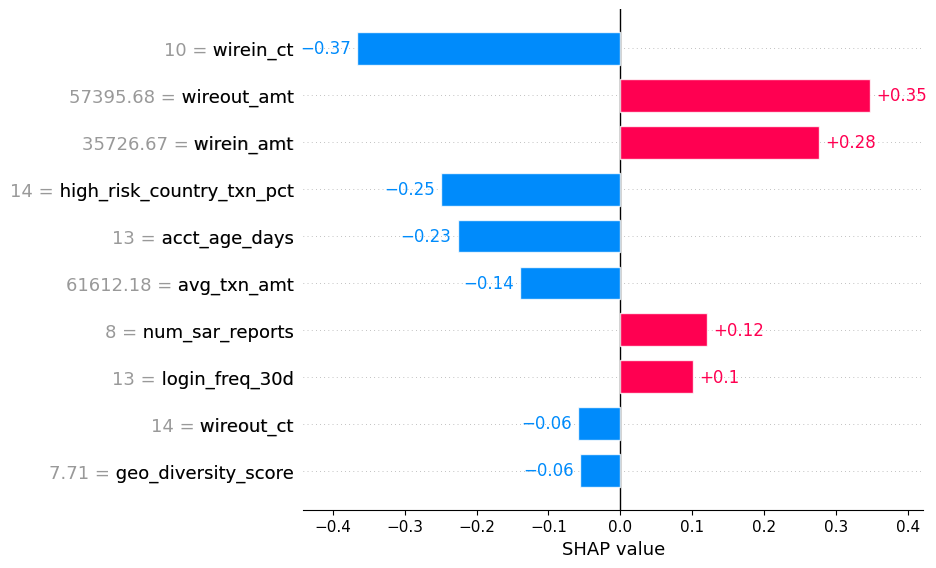

In [29]:
# Example: Plot for entity_id = 1

explanation = gd.load_shap_explanation(input_data_path, entity_id=1)
shap.plots.bar(explanation)

In [30]:
top_n = 5

seg = ["wirein_ct", "wireout_ct", "wirein_amt", "wireout_amt", "avg_txn_amt"]

with open(input_data_path, "r") as f:
    entity_data = json.loads(f.readline())  # Get first entity

feature_library_df = gd.create_realistic_aml_feature_library()
prompt = pg.build_feature_contribution_prompt_from_structured_json(entity_data, feature_library_df, top_n=top_n, selected_features=seg)
print(prompt)

You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score for entity ID 1.

Entity ID: 1
Risk Score: 0%
Top Features and Contributions:
- wirein_ct (Number of wire inbound transactions): 18.9% contribution
- wireout_amt (Total outbound wire amount): 17.9% contribution
- wirein_amt (Total inbound wire amount): 14.2% contribution
- avg_txn_amt (Average transaction amount): 7.2% contribution
- wireout_ct (Number of wire outbound transactions): 3.0% contribution

Please produce a narrative that:
- Starts with the risk score
- Explains each feature’s contribution in plain language
- Highlights why each feature might indicate a higher risk



In [31]:
# Load structured dataset
with open(input_data_path, "r") as f:
    entity_data_list = [json.loads(line) for line in f]

In [ ]:
entity_data_list[0]

In [32]:
# Add prompt column
# df_with_prompts = gd.add_prompt_column(entity_data_list, feature_library_df, top_n=5)
df_with_prompts = gd.add_prompt_to_entity_json(entity_data_list, feature_library_df, top_n=top_n, selected_features=seg)
output_data_path = "../data/output/entities_with_prompts.json"
gd.save_entities_to_json(df_with_prompts, output_data_path)

✅ Entities saved to ../data/output/entities_with_prompts.json


In [ ]:
# Assume seg1, seg2, seg3, seg4 are predefined lists of features
segments = [seg1, seg2, seg3, seg4]

# Split the data into chunks of 25 and apply the corresponding segment
chunk_size = 25
df_with_prompts = []

for i, seg in enumerate(segments):
    start = i * chunk_size
    end = start + chunk_size
    chunk = entity_data_list[start:end]

    updated_chunk = gd.add_prompt_to_entity_json(
        chunk,
        feature_library_df,
        top_n=top_n,
        selected_features=seg
    )
    df_with_prompts.extend(updated_chunk)

In [ ]:
df_with_prompts[0]

In [33]:
# Load structured dataset
with open(output_data_path, "r") as f:
    entity_data_list = json.load(f)

In [ ]:
entity_data_list[0]

In [34]:
# output_data_path = "../data/output/entities_with_prompts.json"

updated_entities = gd.enrich_entities_with_llm_explanations(
    input_json_path="../data/output/entities_with_prompts.json",
    output_json_path="../data/output/entities_with_llm_explanations.json",
    feature_library_df=feature_library_df,
    azure_client=azure_client,
    top_n=top_n,
    log_every_n=25# New parameter for logging frequency
)

Processed entity 25/100
Processed entity 50/100
Processed entity 75/100
Processed entity 100/100
✅ Saved enriched entities with explanations to ../data/output/entities_with_llm_explanations.json


In [35]:
with open("../data/output/entities_with_llm_explanations.json", "r") as f:
    output = json.load(f)

In [ ]:
output[0]

In [36]:
enriched_entities = gd.enrich_and_evaluate_entities(
    input_json_path="../data/output/entities_with_llm_explanations.json",
    output_json_path="../data/output/entities_enriched_evaluated.json",
    feature_library_df=feature_library_df,
    azure_client=azure_client,
    judge_models=judge.MOCK_JUDGE_MODELS,
    top_n=top_n,
    log_every_n=25  # print progress every 3 entities
)

✅ Processed 25/100 entities
✅ Processed 50/100 entities
✅ Processed 75/100 entities
✅ Processed 100/100 entities
✅ Evaluations completed and saved to ../data/output/entities_enriched_evaluated.json


In [37]:
with open("../data/output/entities_enriched_evaluated.json", "r") as f:
    output = json.load(f)

In [ ]:
output[0]

In [38]:
entity_data_list = gd.update_mean_std_scores_in_json(
    input_json_path="../data/output/entities_enriched_evaluated.json",
    output_json_path="../data/output/entities_with_stats.json"
)

✅ Per-entity stats saved to: ../data/output/entities_with_stats.json


In [39]:
with open("../data/output/entities_with_stats.json", "r") as f:
    output = json.load(f)

In [ ]:
len(output), output[0]

In [14]:
final = dict()
final['model_1'] = output

In [15]:
len(final)

1

In [ ]:
gd.show_dict_structure(output[0])

In [ ]:
gd.display_dict_structure(output[0])

In [ ]:
output[:2]

Figure saved to: ../data/output/evaluation_scores.png


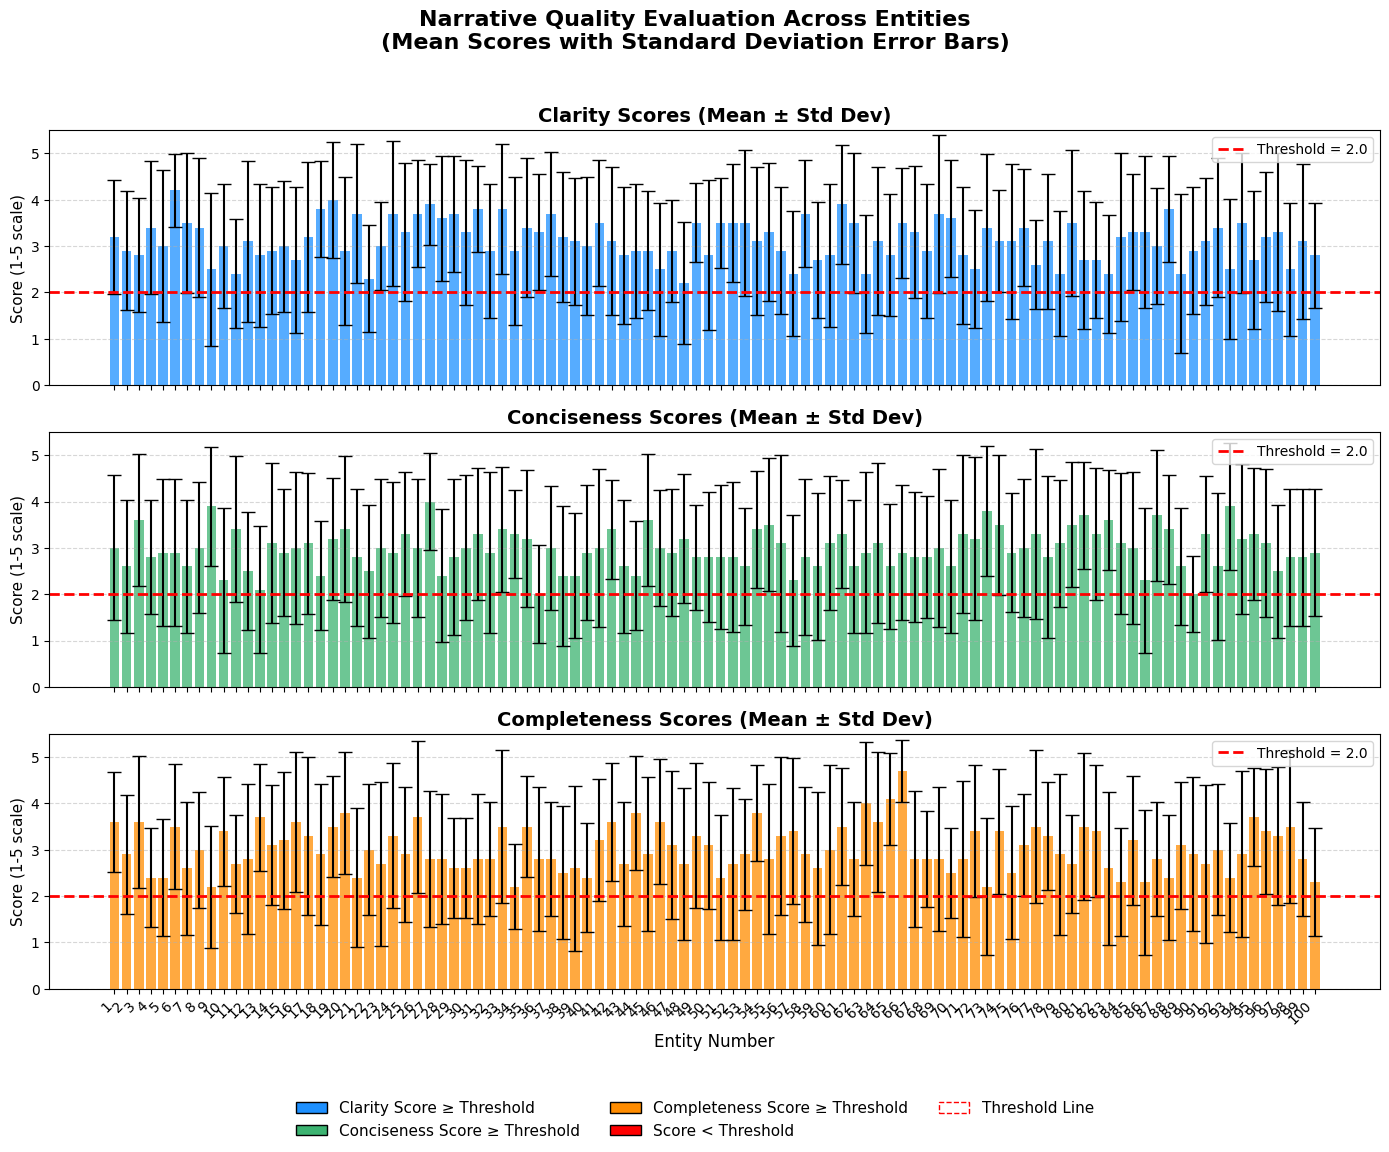

In [40]:
threshold = 2.0

gd.plot_entity_quality_stats_business(output, threshold=threshold, save_path="../data/output/evaluation_scores.png")

In [41]:
# Example usage:
below_thresh_ids = gd.get_entities_below_threshold(output, threshold=threshold)
print("Entities below threshold:", below_thresh_ids)

Entities below threshold: []


In [42]:
len(below_thresh_ids)

0

In [43]:
# Sample list of entity IDs to keep
target_ids = below_thresh_ids  # replace with your actual list

# Filtered data
filtered_data = [entity for entity in output if entity['entity_id'] in target_ids]

# gd.plot_entity_quality_stats_business(filtered_data, threshold=threshold, save_path="../data/output/evaluation_scores_2.png")

In [44]:
print(target_ids)

[]


In [12]:
# entity IDs you want to plot
selected_ids = [31]

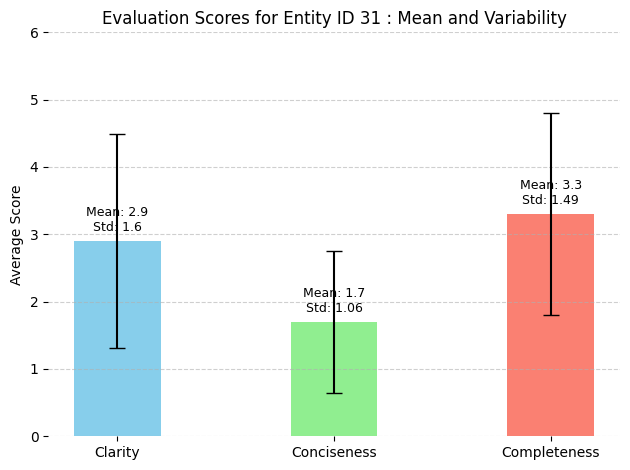

In [13]:
# call the function
gd.plot_evaluation_stats(filtered_data, selected_ids)

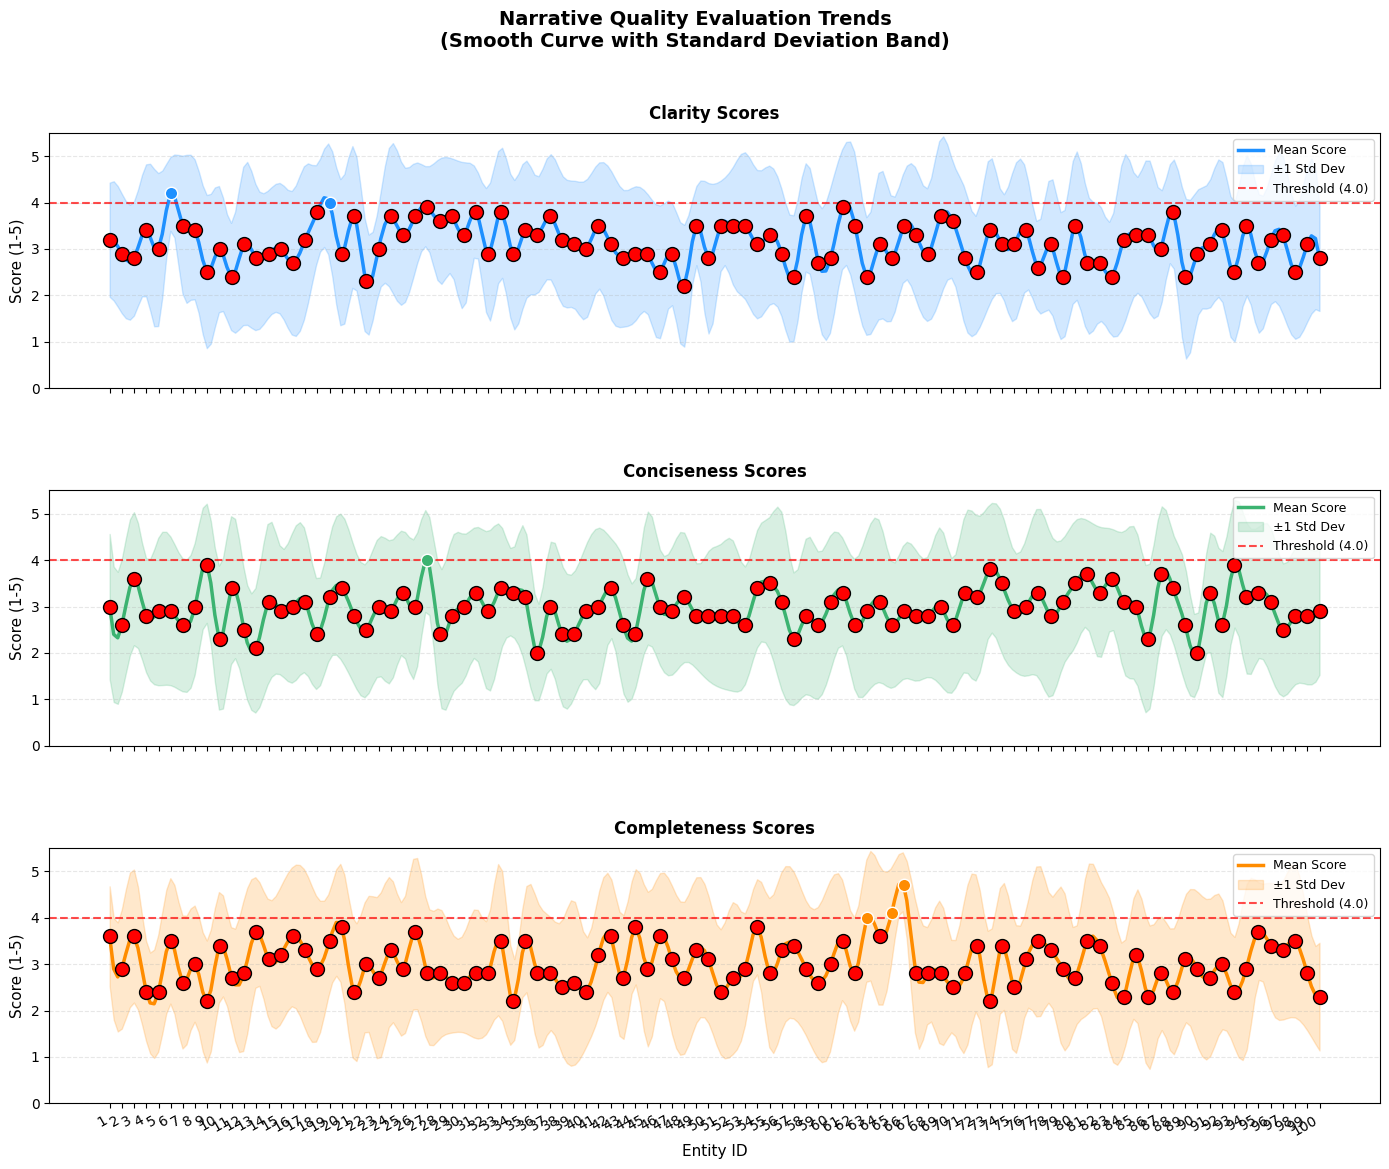

In [45]:
gd.plot_entity_quality_stats_business_curve(output, threshold=4.0, save_path=None)

In [33]:
with open("../data/input/generating_model_entity_data.json", "r") as f:
    test = json.load(f)

In [ ]:
test

In [15]:
import json

with open("../data/output/final.json", "r") as f:
    test = json.load(f)

In [16]:
len(test)

5

In [ ]:
# Example usage with your data:
# gd.plot_model_metric_trends(test, save_prefix="model_comparison")
gd.plot_model_metric_trends_combined_vertical(test, 
                                     save_path="../data/output/model_metrics_combined.png")

In [17]:
len(test)

5

In [18]:
for k, v in test.items():
    print(k)

model_1
model_2
model_3
model_4
model_5


In [19]:
# m = ["GPT-4o-finetuned-risk-explainer"]
m = ["model_1"]

filtered = {k: v for k, v in test.items() if k in m}  # {'c': 3, 'd': 4}

Figure saved to: ../data/output/model_comparison_combined.png


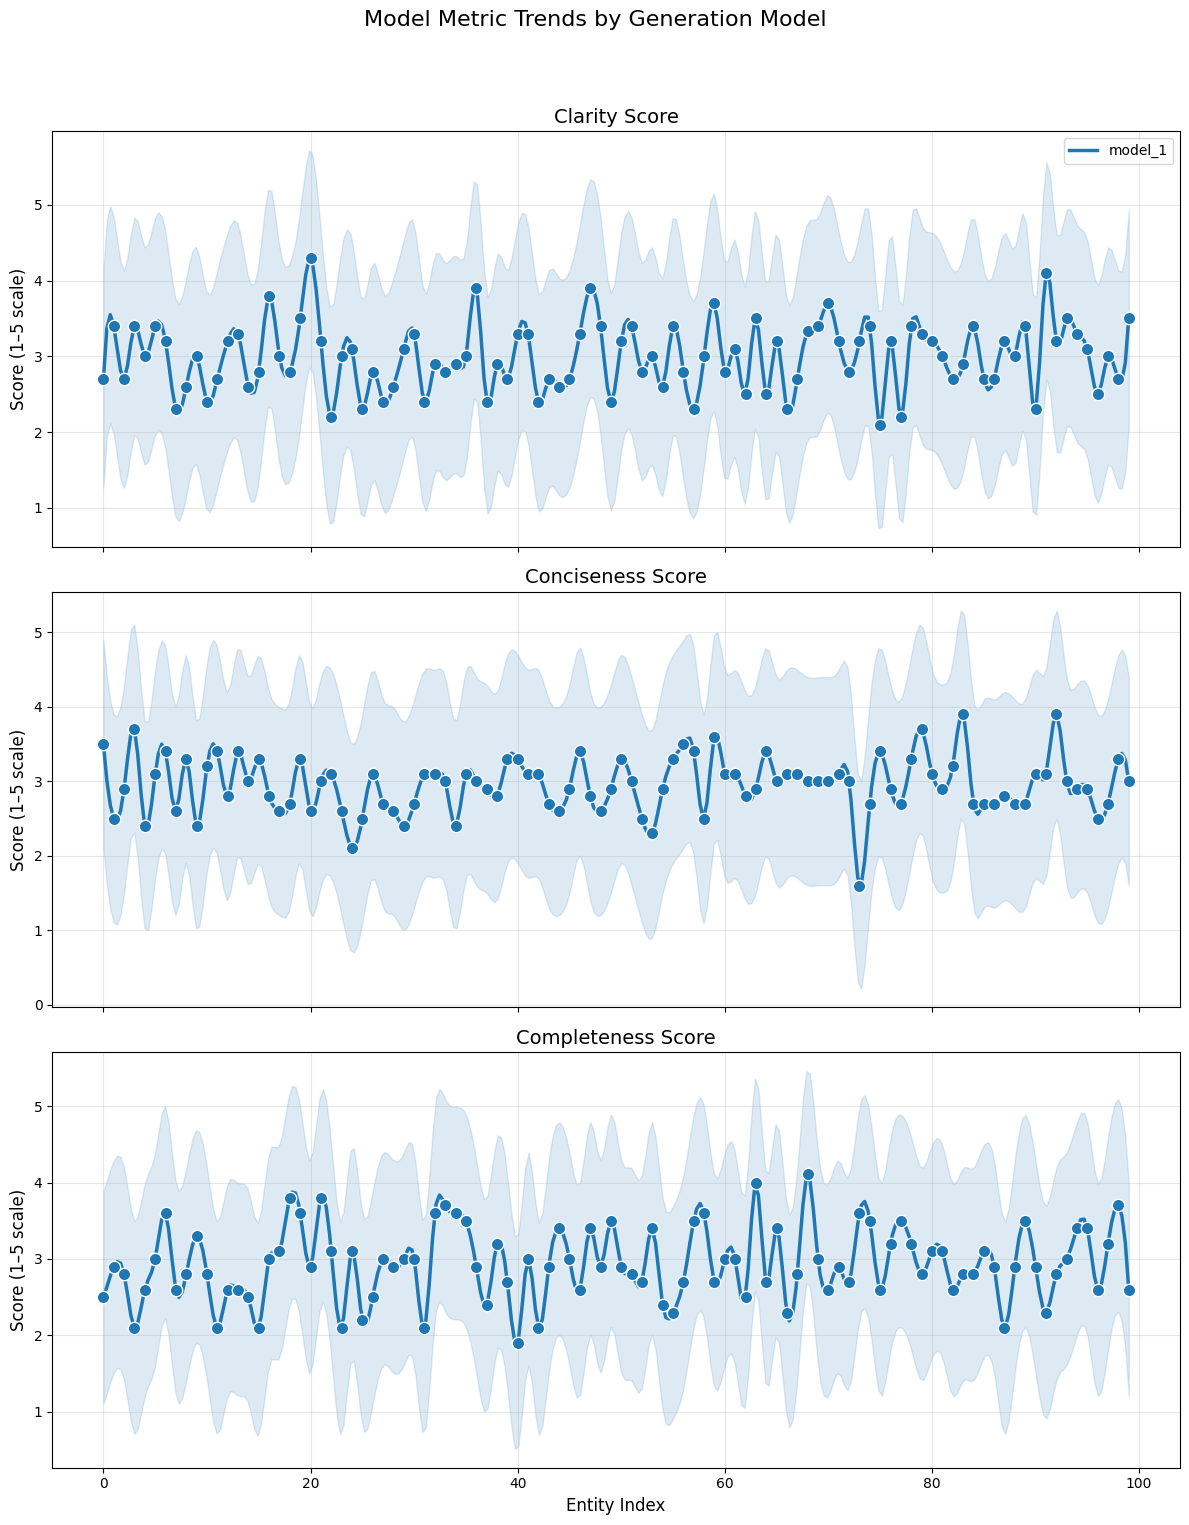

In [20]:
# gd.plot_model_metric_trends(filtered, save_prefix="model_comparison")
gd.plot_model_metric_trends_combined_vertical(filtered, 
                                     save_path="../data/output/model_comparison_combined.png")

In [ ]:
output[0]

In [ ]:
gd.print_business_friendly_summary(output[0])

In [21]:
len(test["model_1"])

100

In [22]:
output_path = "../data/output/"

In [23]:
gd.print_business_friendly_summary(test["model_1"][0], output_basename=output_path)


 Entity ID: 1 |  Risk Score: 44%

 Top Contributing Features:
+---------------------+------------------+
| Feature             | Contribution %   |
+=====================+==================+
| acct_age_days       | 31.1%            |
+---------------------+------------------+
| num_sar_reports     | 14.2%            |
+---------------------+------------------+
| login_freq_30d      | 11.6%            |
+---------------------+------------------+
| wirein_amt          | 10.4%            |
+---------------------+------------------+
| geo_diversity_score | 9.4%             |
+---------------------+------------------+

 Prompt Given to LLM:
You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score for entity ID 1.

Entity ID: 1
Risk Score: 44%
Top Features and Contributions:
- acct_age_days (Account age in days): 31.1% contribution
- num_sar_reports (Number o